# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, butter, sosfilt, sosfreqz, freqz, resample
import soundfile as sf
import pandas as pd

# ANSI S1.11 STANDARD

## Paramètres globaux

In [2]:
fs = 24000 # fréquence d'échantillonnage
bands = np.arange(22, 40)   # bande 22 → 39
Nbands = len(bands) # nombre de bandes

## Calcul des fréquences ANSI 1/3 octave

In [3]:
def ansi_band(n):
    f0 = 1000 * 2 ** ((n - 30) / 3)
    fl = f0 / 2 ** (1/6)
    fu = f0 * 2 ** (1/6)
    return fl, f0, fu

# stockage des filtres
filters_FIR = []
filters_IIR = []

## Design des filtres FIR et IIR

In [4]:
for n in bands:
    # Pour chaque bande ANSI, on calcule les fréquences de coupure et on normalise (scipy)
    fl, f0, fu = ansi_band(n)
    
    fl /= fs/2
    fu /= fs/2

    # FIR 1/3 octave (bandpass)
    taps = firwin(                 # design FIR windowed (méthode de Hamming)
        numtaps=129,               # (ordre 128)
        cutoff=[fl, fu],           # bande passante
        pass_zero=False
    )
    filters_FIR.append(taps)

    # IIR Butterworth
    sos = butter(                  # filtre IIR Butterworth d’ordre 4
        N=4,
        Wn=[fl, fu],
        btype='bandpass',
        output='sos'               # second-order sections
    )
    filters_IIR.append(sos)

print("Les 18 filtres 1/3-octave ont été générés avec succès !")

Les 18 filtres 1/3-octave ont été générés avec succès !


Juste pour rappelle :')
Un SOS d'ordre 2 (ce que l'on a) est de la forme :

$$H_i(z) = 
\frac{
b_{0,i} + b_{1,i} z^{-1} + b_{2,i} z^{-2}
}{
1 + a_{1,i} z^{-1} + a_{2,i} z^{-2}
}
$$

## Plot des réponses fréquentielles (FIR)

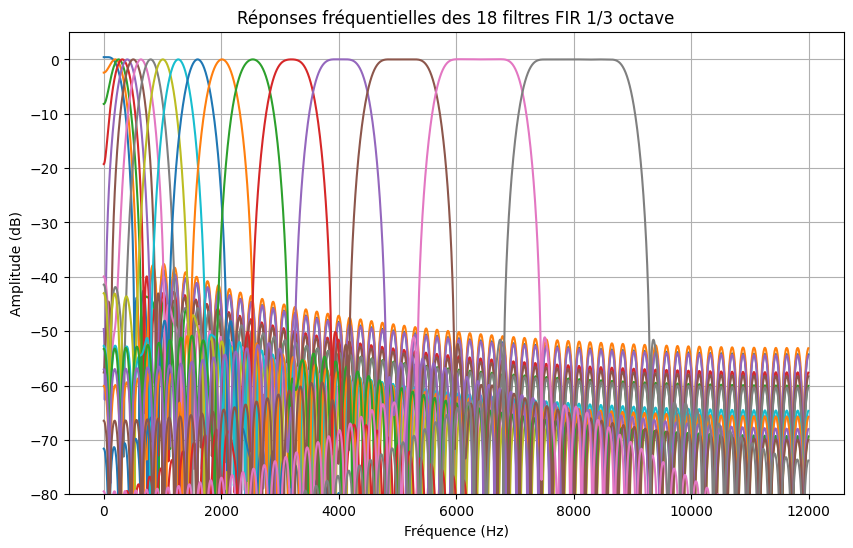

In [5]:
plt.figure(figsize=(10,6))
for taps in filters_FIR:
    w, h = freqz(taps, [1], worN=2048, fs=fs) # réponse en fréquence FIR
    plt.plot(w, 20*np.log10(np.abs(h)))

plt.title("Réponses fréquentielles des 18 filtres FIR 1/3 octave")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude (dB)")
plt.grid(True)
plt.ylim([-80, 5])
plt.show()

## Test sur audio

In [6]:
signal, fs_in = sf.read("test.wav")

# Convertir en mono si stéréo
if signal.ndim > 1:
    signal = np.mean(signal, axis=1)

# Resample si besoin
if fs_in != fs:
    signal = resample(signal, int(len(signal) * fs / fs_in))
    print(f"Audio resamplé de {fs_in} Hz à {fs} Hz")

filtered_bands = []

#for taps in filters_FIR:
#    filtered_sig = np.convolve(signal, taps, mode='same')

for sos in filters_IIR:
    filtered_sig = sosfilt(sos, signal)
    filtered_bands.append(filtered_sig)

filtered_bands = np.array(filtered_bands).T

print("Filtrage terminé !")

Audio resamplé de 44100 Hz à 24000 Hz
Filtrage terminé !


## Sauvegarde des bandes filtrées

In [7]:
# Sauvegarde des bandes filtrées
import os
if not os.path.exists('filtered_bands'):
    os.makedirs('filtered_bands')

for i, band in enumerate(bands):
    filename = f"filtered_bands/band_{band}.wav"
    sf.write(filename, filtered_bands[:, i], fs)
    print(f"Bande {band} sauvegardée dans {filename}")

print("Toutes les bandes filtrées ont été sauvegardées !")

Bande 22 sauvegardée dans filtered_bands/band_22.wav
Bande 23 sauvegardée dans filtered_bands/band_23.wav
Bande 24 sauvegardée dans filtered_bands/band_24.wav
Bande 25 sauvegardée dans filtered_bands/band_25.wav
Bande 26 sauvegardée dans filtered_bands/band_26.wav
Bande 27 sauvegardée dans filtered_bands/band_27.wav
Bande 28 sauvegardée dans filtered_bands/band_28.wav
Bande 29 sauvegardée dans filtered_bands/band_29.wav
Bande 30 sauvegardée dans filtered_bands/band_30.wav
Bande 31 sauvegardée dans filtered_bands/band_31.wav
Bande 32 sauvegardée dans filtered_bands/band_32.wav
Bande 33 sauvegardée dans filtered_bands/band_33.wav
Bande 34 sauvegardée dans filtered_bands/band_34.wav
Bande 35 sauvegardée dans filtered_bands/band_35.wav
Bande 36 sauvegardée dans filtered_bands/band_36.wav
Bande 37 sauvegardée dans filtered_bands/band_37.wav
Bande 38 sauvegardée dans filtered_bands/band_38.wav
Bande 39 sauvegardée dans filtered_bands/band_39.wav
Toutes les bandes filtrées ont été sauvegardée

## Plot de comparaison FIR vs IIR

/tmp/ipykernel_106401/3274457603.py:11: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w2, 20*np.log10(np.abs(h2)), '--', label="IIR")


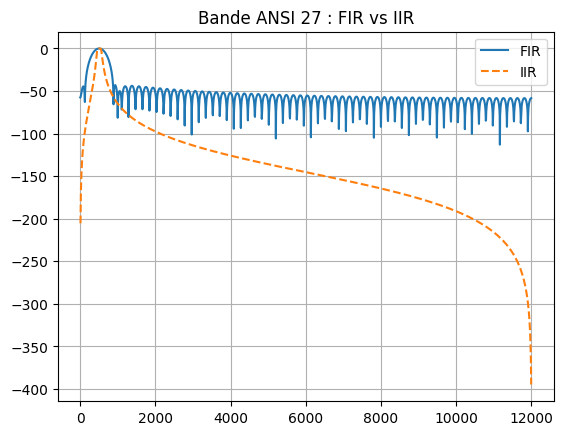

In [8]:
k = 5  # bande 27
taps = filters_FIR[k]
sos = filters_IIR[k]

# FIR
w, h = freqz(taps, [1], worN=2048, fs=fs)
plt.plot(w, 20*np.log10(np.abs(h)), label="FIR")

# IIR
w2, h2 = sosfreqz(sos, worN=2048, fs=fs)
plt.plot(w2, 20*np.log10(np.abs(h2)), '--', label="IIR")

plt.legend()
plt.grid(True)
plt.title(f"Bande ANSI {bands[k]} : FIR vs IIR")
plt.show()

In [ ]:
# Tableau des ordres des filtres FIR/IIR pour chaque bande 1/3 octave
# Je ne vois pas l'intérêt de ce tableau, a ce niveau là (car ANSI S1.11 Standar) mais bon...
data = []
for i, band in enumerate(bands):
    fir_order = len(filters_FIR[i]) - 1  # ordre = taps - 1
    iir_order = 4  # Butterworth N=4
    data.append([band, fir_order, iir_order])

df = pd.DataFrame(data, columns=['Bande ANSI', 'Ordre FIR', 'Ordre IIR'])
df

,Bande ANSI,Ordre FIR,Ordre IIR
0,22,128,4
1,23,128,4
2,24,128,4
3,25,128,4
4,26,128,4
5,27,128,4
6,28,128,4
7,29,128,4
8,30,128,4
9,31,128,4


In [ ]:
def quantize(coeffs, word_length, integer_bits=1):
    """
    Quantifie des coefficients en format virgule fixe Qm.n.
    
    Qm.n = m bits partie entière (avec signe) + n bits fractionnaire.
    Ici : Q(integer_bits).(word_length - 1 - integer_bits)
    
    Exemples:
    - quantize(coeffs, 8, 1)  -> Q1.6
    - quantize(coeffs, 16, 3) -> Q3.12
    
    Args:
        coeffs: array des coefficients (float)
        word_length: bits total (int > integer_bits + 1)
        integer_bits: bits partie entière (1 pour FIR, 3+ pour IIR)
    
    Returns:
        array: coefficients quantifiés (float arrondis)
    """
    
    if word_length <= integer_bits + 1:
        raise ValueError("Word length trop petit.")
    
    frac_bits = word_length - 1 - integer_bits
    scale = 2**frac_bits
    q = np.round(coeffs * scale) / scale
    
    return q

/tmp/ipykernel_106401/2323181081.py:30: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w_iir, 20*np.log10(np.abs(h_iir)), '--', label='IIR quantisé')
/home/maxime/.local/lib/python3.10/site-packages/scipy/signal/_filter_design.py:482: RuntimeWarning: divide by zero encountered in divide
  h = (npp_polyval(zm1, b, tensor=False) /
/home/maxime/.local/lib/python3.10/site-packages/scipy/signal/_filter_design.py:482: RuntimeWarning: invalid value encountered in divide
  h = (npp_polyval(zm1, b, tensor=False) /
/home/maxime/.local/lib/python3.10/site-packages/scipy/signal/_filter_design.py:861: RuntimeWarning: invalid value encountered in multiply
  h *= rowh
/tmp/ipykernel_106401/2323181081.py:29: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w_fir, 20*np.log10(np.abs(h_fir)), label='FIR quantisé')


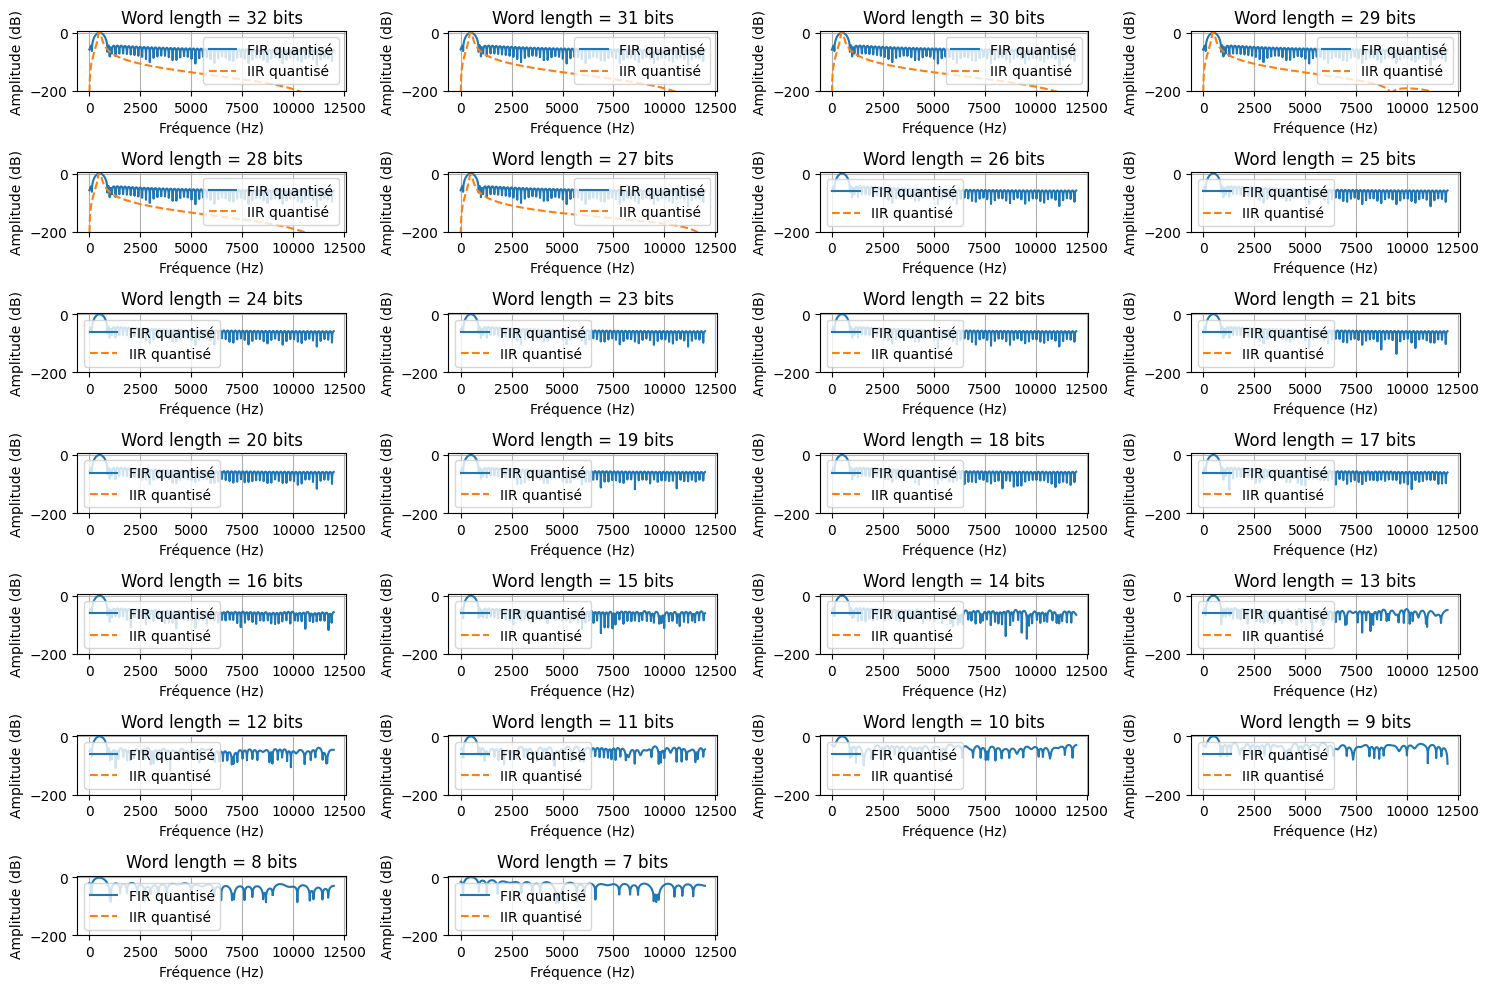

In [ ]:
word_lengths = list(range(32, 6, -1))  # 32 → 7 bits

k = 5  # bande 27
taps_original = filters_FIR[k]
sos_original = filters_IIR[k]

plt.figure(figsize=(15, 10))

for i, wl in enumerate(word_lengths):

    # FIR quantifié
    taps_q = quantize(taps_original, wl, integer_bits=1)  # FIR

    # IIR quantifié 
    sos_q = sos_original.copy()

    # b0,b1,b2 : coefficients du numérateur, peuvent dépasser 1, d'où 3 bits entier
    sos_q[:, :3] = quantize(sos_original[:, :3], wl, integer_bits=3)

    # a1,a2 : coefficients du dénominateur, même logique
    sos_q[:, 4:] = quantize(sos_original[:, 4:], wl, integer_bits=3)
    
    # a0 : reste à 1.0 (normalisation des SOS, donc pas besoin de quantifier)
    # Je pense que en pratique il ne faudrait pas le quatifier, car ça fausserait la normalisation
    sos_q[:, 3] = 1.0

    # Réponses freq
    w_fir, h_fir = freqz(taps_q, [1], worN=2048, fs=fs)
    w_iir, h_iir = sosfreqz(sos_q, worN=2048, fs=fs)

    plt.subplot(len(word_lengths)//4 + 1, 4, i+1)
    plt.plot(w_fir, 20*np.log10(np.abs(h_fir)), label='FIR quantisé')
    plt.plot(w_iir, 20*np.log10(np.abs(h_iir)), '--', label='IIR quantisé')
    plt.title(f'Word length = {wl} bits')
    plt.xlabel('Fréquence (Hz)')
    plt.ylabel('Amplitude (dB)')
    plt.grid(True)
    plt.ylim([-200, 5])
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print("\n=== Exemple quantif FIR / IIR pour WL = 8 bits ===")
print("Taps FIR orig :", taps_original[:5])
print("Taps FIR q8   :", quantize(taps_original, 8, integer_bits=1)[:5])

print("\nSOS orig :\n", sos_original)
sos_q8 = sos_original.copy()

# Petit rapelle ;') 
# sos_original[:, :3] veut dire toutes les lignes, mais seulement les 3 premières colonnes donc b0, b1, b2
sos_q8[:, :3] = quantize(sos_original[:, :3], 8, integer_bits=3)
sos_q8[:, 4:] = quantize(sos_original[:, 4:], 8, integer_bits=3)
sos_q8[:, 3] = 1.0
print("\nSOS q8 :\n", sos_q8)


=== Exemple quantif FIR / IIR pour WL = 8 bits ===
Taps FIR orig : [-0.00111086 -0.00088893 -0.00065454 -0.00040081 -0.00012054]
Taps FIR q8   : [-0. -0. -0. -0. -0.]

SOS orig :
 [[ 5.07278137e-08  1.01455627e-07  5.07278137e-08  1.00000000e+00
  -1.95274233e+00  9.71176329e-01]
 [ 1.00000000e+00  2.00000000e+00  1.00000000e+00  1.00000000e+00
  -1.95813991e+00  9.73587760e-01]
 [ 1.00000000e+00 -2.00000000e+00  1.00000000e+00  1.00000000e+00
  -1.96620991e+00  9.87255630e-01]
 [ 1.00000000e+00 -2.00000000e+00  1.00000000e+00  1.00000000e+00
  -1.97593271e+00  9.89682908e-01]]

SOS q8 :
 [[ 0.      0.      0.      1.     -1.9375  1.    ]
 [ 1.      2.      1.      1.     -1.9375  1.    ]
 [ 1.     -2.      1.      1.     -1.9375  1.    ]
 [ 1.     -2.      1.      1.     -2.      1.    ]]


## Interprétation

ICI, chaque ligne du tableau SOS correspond à une section IIR d’ordre 2.  
Le filtre complet est obtenu en mettant toutes ces sections **en cascade**.

Un SOS est toujours de la forme :

[b0  b1  b2   a0  a1  a2] avec **a0 = 1** (normalisation standard).

Les filtres 1/3-octave ANSI S1.11 sont très étroits : leurs pôles sont
proches du cercle unité, donc une très petite erreur sur a1 ou a2 peut
modifier fortement la réponse ou rendre le filtre instable.

À l’inverse, les FIR n’ont **pas de rétroaction**, sont toujours stables et
supportent beaucoup mieux la quantification fixe.
